In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
torch.cuda.set_device(0)
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split


In [ ]:
masks = glob.glob("Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_path.replace("_mask", "") for mask_path in masks]
series = []
for img_path, mask_path in zip(images, masks):
    if os.path.exists(img_path) and os.path.exists(mask_path):
        series.append((img_path, mask_path))
print(series[:4])

[('Dataset_BUSI_with_GT\\benign\\benign (1).png', 'Dataset_BUSI_with_GT\\benign\\benign (1)_mask.png'), ('Dataset_BUSI_with_GT\\benign\\benign (10).png', 'Dataset_BUSI_with_GT\\benign\\benign (10)_mask.png'), ('Dataset_BUSI_with_GT\\benign\\benign (100).png', 'Dataset_BUSI_with_GT\\benign\\benign (100)_mask.png'), ('Dataset_BUSI_with_GT\\benign\\benign (101).png', 'Dataset_BUSI_with_GT\\benign\\benign (101)_mask.png')]


In [3]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])
    
    f, axarr = plt.subplots(1, 3, figsize=(5, 5))
    
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel('Axial View', fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

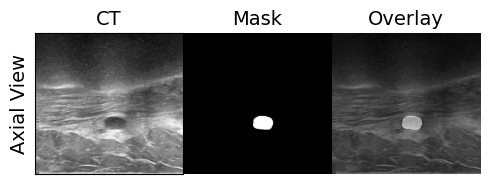

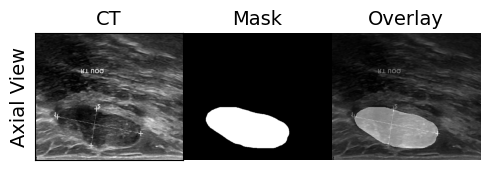

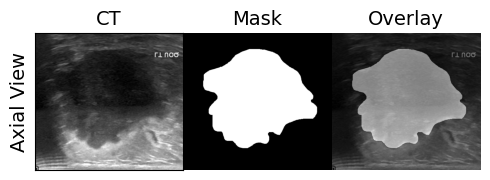

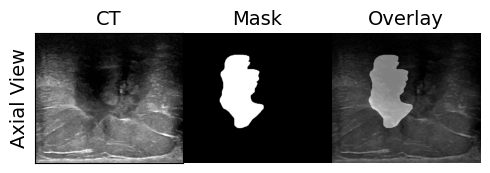

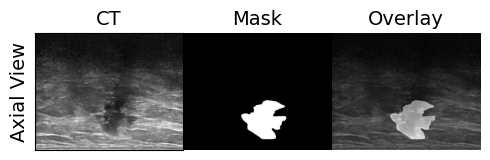

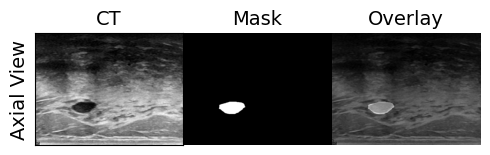

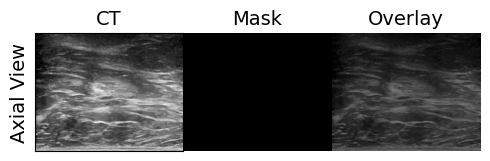

In [4]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_label(series[image])

In [5]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])

In [6]:
dataset

,image_path,mask_path
0,Dataset_BUSI_with_GT\benign\benign (1).png,Dataset_BUSI_with_GT\benign\benign (1)_mask.png
1,Dataset_BUSI_with_GT\benign\benign (10).png,Dataset_BUSI_with_GT\benign\benign (10)_mask.png
2,Dataset_BUSI_with_GT\benign\benign (100).png,Dataset_BUSI_with_GT\benign\benign (100)_mask.png
3,Dataset_BUSI_with_GT\benign\benign (101).png,Dataset_BUSI_with_GT\benign\benign (101)_mask.png
4,Dataset_BUSI_with_GT\benign\benign (102).png,Dataset_BUSI_with_GT\benign\benign (102)_mask.png
...,...,...
775,Dataset_BUSI_with_GT\normal\normal (95).png,Dataset_BUSI_with_GT\normal\normal (95)_mask.png
776,Dataset_BUSI_with_GT\normal\normal (96).png,Dataset_BUSI_with_GT\normal\normal (96)_mask.png
777,Dataset_BUSI_with_GT\normal\normal (97).png,Dataset_BUSI_with_GT\normal\normal (97)_mask.png
778,Dataset_BUSI_with_GT\normal\normal (98).png,Dataset_BUSI_with_GT\normal\normal (98)_mask.png


In [7]:
train, test= train_test_split(dataset, test_size=0.25)

In [8]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (585, 2)
Test shape: (195, 2)


In [9]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomImageMaskDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L') 
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

# Define transformations with selected augmentation techniques and normalization for grayscale
image_size = 128
    
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

# Create DataLoaders
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
for batch in train_dataloader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch
    
    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda', index=0)

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()
        
        self.dropout = nn.Dropout(dropout)
        
        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)
        
        x = self.dropout(x)
        
        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x

class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p

class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        self.conv2d_1 = ConvBlock(output_channel*2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, skip):
        x = self.conv_t(x)
        x = torch.cat([x, skip], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

In [14]:
class Unet(nn.Module):

    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.07)
        self.encoder_2 = Encoder(64, 128, 0.08)
        self.encoder_3 = Encoder(128, 256, 0.09)
        self.encoder_4 = Encoder(256, 512, 0.1)

        self.conv_block = ConvBlock(512, 1024, 0.11)

        self.decoder_1 = Decoder(1024, 512, 0.1)
        self.decoder_2 = Decoder(512, 256, 0.09)
        self.decoder_3 = Decoder(256, 128, 0.08)
        self.decoder_4 = Decoder(128, 64, 0.07)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid() 

    def forward(self, x):

        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)

        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)

        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)
        
        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final


In [15]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15

        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice
    
    def iou(self, pred_mask, true_mask):
        intersection = torch.logical_and(pred_mask, true_mask).sum().item()
        union = torch.logical_or(pred_mask, true_mask).sum().item()
        iou_score = intersection / union if union != 0 else 0.0
        return iou_score

    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            self.save_best_model(epoch + 1, avg_val_dice)
    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }

In [16]:
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score

In [17]:
unet = Unet(1).to(device)

In [18]:
learning_rate = 0.0001
weight_decay = 1e-6  # Regularization term to prevent overfitting

optimizer = optim.Adam(unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Trainer(model=unet, num_epochs=10000, optimizer=optimizer, criterion=bce_dice_loss, device=device)

In [19]:
trainer.train(train_dataloader, test_dataloader)
metrics = trainer.get_metrics()

Epoch [1/10000], Step [15/37], Loss: 1.4937, Dice Coef: 0.1380
Epoch [1/10000], Step [30/37], Loss: 1.4345, Dice Coef: 0.1266
Epoch [1/10000], Train Loss: 1.4418, Val Loss: 1.3284
Epoch [1/10000], Train Dice: 0.1683, Val Dice: 0.1467
Epoch [2/10000], Step [15/37], Loss: 1.1751, Dice Coef: 0.2366
Epoch [2/10000], Step [30/37], Loss: 1.1918, Dice Coef: 0.2230
Epoch [2/10000], Train Loss: 1.1839, Val Loss: 1.1207
Epoch [2/10000], Train Dice: 0.2390, Val Dice: 0.2640
Epoch [3/10000], Step [15/37], Loss: 1.2209, Dice Coef: 0.1687
Epoch [3/10000], Step [30/37], Loss: 1.1815, Dice Coef: 0.2651
Epoch [3/10000], Train Loss: 1.1193, Val Loss: 1.1499
Epoch [3/10000], Train Dice: 0.2604, Val Dice: 0.3022
Epoch [4/10000], Step [15/37], Loss: 1.0953, Dice Coef: 0.2459
Epoch [4/10000], Step [30/37], Loss: 1.0082, Dice Coef: 0.3198
Epoch [4/10000], Train Loss: 1.0689, Val Loss: 1.0491
Epoch [4/10000], Train Dice: 0.2796, Val Dice: 0.2844
Epoch [5/10000], Step [15/37], Loss: 1.0572, Dice Coef: 0.2602
E

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 15.92 GiB of which 0 bytes is free. Of the allocated memory 59.97 GiB is allocated by PyTorch, and 975.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

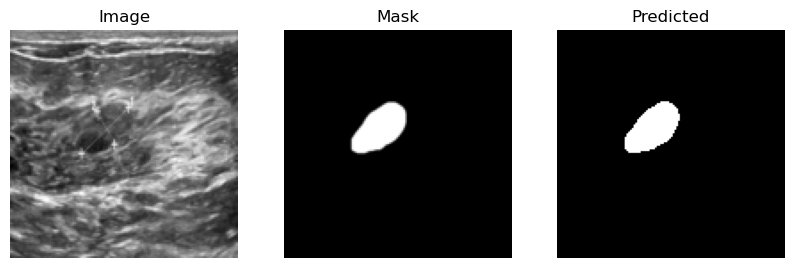

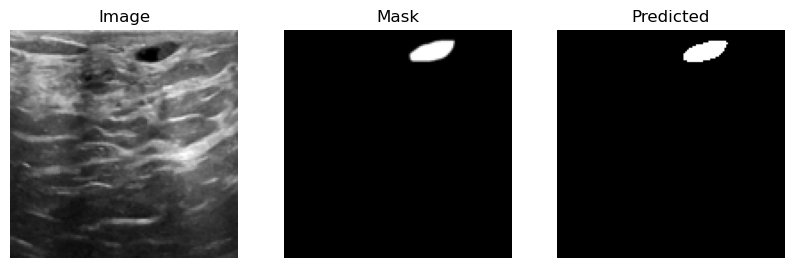

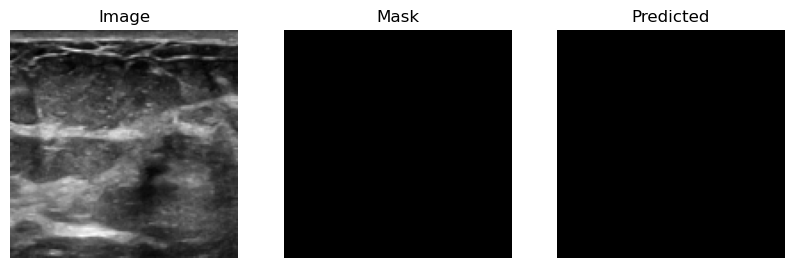

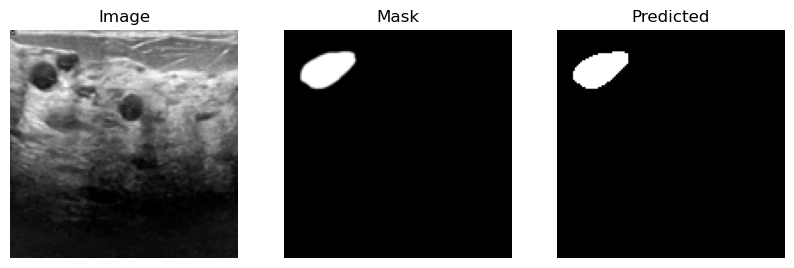

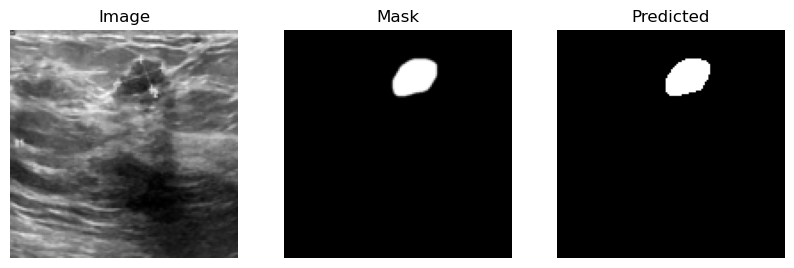

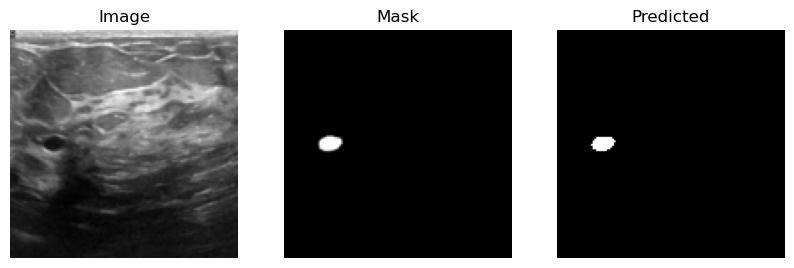

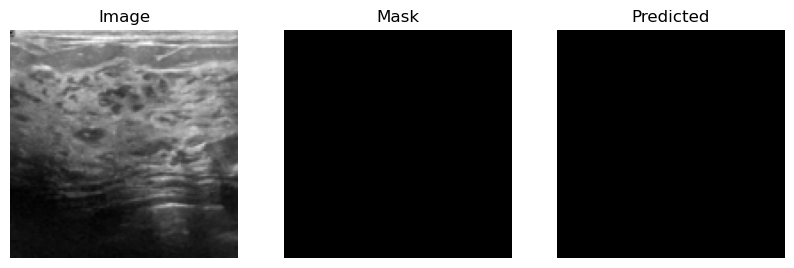

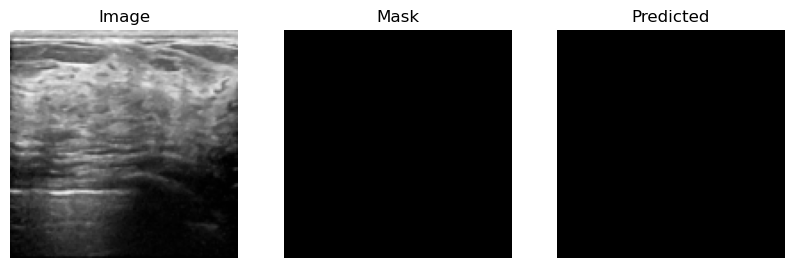

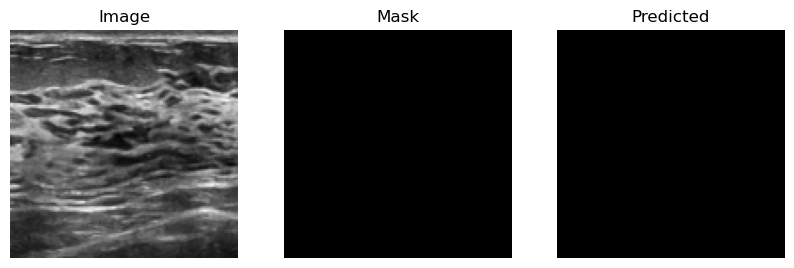

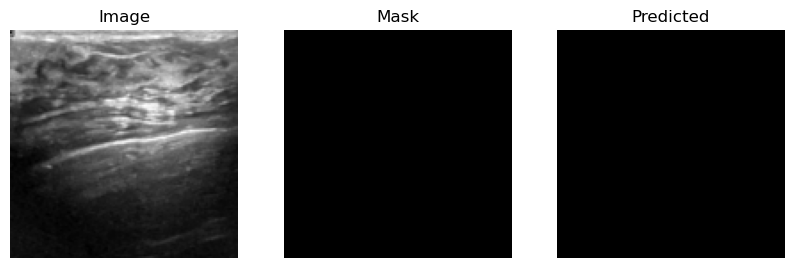

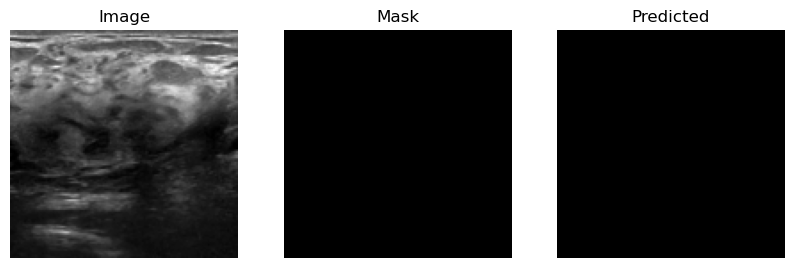

In [ ]:
for i in [2, 3, 11, 20, 55, 67, 87, 98, 120, 130, 200]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

In [1]:
"""
BitNet‑Swin: 1‑bit (binary) Transformer blocks for vision models
-------------------------------------------------------------------------------
This is a research prototype that adapts BitNet‑style 1‑bit linear layers to a
Swin Transformer backbone for image classification. It focuses on:
  • BitLinear: 1‑bit weight quantization with per‑output‑channel scaling and
    straight‑through estimator (STE) for gradients.
  • Optional activation binarization (off by default) with learnable clip range.
  • Drop‑in replacements for nn.Linear inside Swin MLP and Attention (QKV/out).
  • Toggle which submodules are binarized via BitSwinConfig.

Notes
-----
- This file aims to be easy to read/modify rather than micro‑optimized.
- By default only weights are binarized; activations remain FP16/FP32.
- It supports mixed precision and torch.compile, though both are optional.
- Export and bit‑packing for inference is sketched but optional.

Tested with: PyTorch >= 2.2 (CPU). GPU/AMP recommended for real training.
"""
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# Quantization primitives
# ---------------------------
class SignSTE(torch.autograd.Function):
    """Sign with straight‑through estimator for gradients.

    Forward: y = sign(x) with zeros mapped to +1 (common in binarized nets).
    Backward: pass‑through gradients (dL/dx = dL/dy clipped by |x|<=1 if desired).
    """
    @staticmethod
    def forward(ctx, x: torch.Tensor, clip_grad: bool = True):
        ctx.save_for_backward(x)
        ctx.clip_grad = clip_grad
        y = x.sign()
        y[y == 0] = 1.0
        return y

    @staticmethod
    def backward(ctx, grad_output):
        (x,) = ctx.saved_tensors
        if ctx.clip_grad:
            # Clip STE to gradients where |x| <= 1 to stabilize training
            mask = (x.abs() <= 1).to(grad_output.dtype)
            return grad_output * mask, None
        else:
            return grad_output, None


def ste_sign(x: torch.Tensor, clip_grad: bool = True) -> torch.Tensor:
    return SignSTE.apply(x, clip_grad)


def channelwise_absmean_scale(w: torch.Tensor, dim: int) -> torch.Tensor:
    """Compute per‑channel scale as mean(|w|) over given dim.
    Typical for binary weights: w_q = s * sign(w).
    For Linear with [out_features, in_features], use dim=1 to reduce over inputs
    -> scale shape [out_features, 1].
    """
    s = w.abs().mean(dim=dim, keepdim=True) + 1e-8
    return s


class LearnableScale(nn.Module):
    """EMA‑initialized, learnable scale per output channel.

    Initialize from abs‑mean and optionally make it learnable with small lr.
    """
    def __init__(self, shape: Tuple[int, ...], init: Optional[torch.Tensor] = None, learnable: bool = True):
        super().__init__()
        if init is None:
            init = torch.ones(shape)
        self.scale = nn.Parameter(init, requires_grad=learnable)

    def forward(self) -> torch.Tensor:
        return self.scale


class ActBinarizer(nn.Module):
    """Optional activation binarization with learnable clip range (DoReFa‑style).

    a_clipped = clamp(a, -clip, clip); a_b = sign(a_clipped)
    """
    def __init__(self, init_clip: float = 1.0, learnable: bool = True):
        super().__init__()
        self.clip = nn.Parameter(torch.tensor(float(init_clip)), requires_grad=learnable)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        c = torch.relu(self.clip) + 1e-6
        return ste_sign(x.clamp(-c, c))


# ---------------------------
# BitLinear
# ---------------------------
class BitLinear(nn.Module):
    """Binary‑weight Linear with per‑channel scaling and optional act binarization.

    Args:
        in_features, out_features: like nn.Linear
        bias: include bias term
        activation_binarization: if True, binarize input activations
        learnable_scale: if True, make the per‑output scale learnable
        ste_clip_grad: clip STE gradient to |x|<=1 region
        init_scale_from_weights: initialize scale from abs‑mean of weights
    """
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        activation_binarization: bool = False,
        learnable_scale: bool = True,
        ste_clip_grad: bool = True,
        init_scale_from_weights: bool = True,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_act_bin = activation_binarization
        self.ste_clip_grad = ste_clip_grad

        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        self.bias = nn.Parameter(torch.empty(out_features)) if bias else None

        # Kaiming init then scale init from abs‑mean
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

        with torch.no_grad():
            if init_scale_from_weights:
                s0 = channelwise_absmean_scale(self.weight, dim=1)
            else:
                s0 = torch.ones((out_features, 1), device=self.weight.device)
        self.scale = LearnableScale((out_features, 1), init=s0, learnable=learnable_scale)

        self.act_bin = ActBinarizer() if self.use_act_bin else None

    def binarize_weight(self) -> torch.Tensor:
        # Per‑output channel scaling
        s = self.scale()
        w_b = ste_sign(self.weight, clip_grad=self.ste_clip_grad)
        return w_b * s  # shape [out, in]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.use_act_bin:
            x = self.act_bin(x)
        wq = self.binarize_weight()
        return F.linear(x, wq, self.bias)


# ---------------------------
# Swin components (minimal)
# ---------------------------

def window_partition(x: torch.Tensor, window_size: int) -> torch.Tensor:
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows: torch.Tensor, window_size: int, H: int, W: int) -> torch.Tensor:
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0., bit_linear_factory=None):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        Linear = bit_linear_factory or nn.Linear
        self.fc1 = Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class WindowAttention(nn.Module):
    """Window based multi‑head self attention (W‑MSA) with relative position bias.
    Replaces Linear layers with BitLinear if provided.
    """
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0., bit_linear_factory=None):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        Linear = bit_linear_factory or nn.Linear
        self.qkv = Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        # Relative position bias table
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads)
        )
        # Index for relative bias
        coords_h = torch.arange(window_size)
        coords_w = torch.arange(window_size)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size - 1
        relative_coords[:, :, 1] += window_size - 1
        relative_coords[:, :, 0] *= 2 * window_size - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)
        nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)

    def forward(self, x):
        B_, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size * self.window_size, self.window_size * self.window_size, -1
        )
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4., qkv_bias=True,
                 drop=0., attn_drop=0., drop_path=0., bit_linear_factory=None):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, window_size=window_size, num_heads=num_heads, qkv_bias=qkv_bias,
                                    attn_drop=attn_drop, proj_drop=drop, bit_linear_factory=bit_linear_factory)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), drop=drop, bit_linear_factory=bit_linear_factory)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # No cyclic shift for simplicity (set shift_size=0). Add if needed.
        x_windows = window_partition(x, self.window_size)  # nW*B, Wh, Ww, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        attn_windows = self.attn(x_windows)  # nW*B, Wh*Ww, C

        x = attn_windows.view(-1, self.window_size, self.window_size, C)
        x = window_reverse(x, self.window_size, H, W)
        x = x.view(B, H * W, C)

        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(4 * dim)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"

        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], -1)
        x = x.view(B, -1, 4 * C)
        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96):
        super().__init__()
        img_size = (img_size, img_size) if isinstance(img_size, int) else img_size
        patch_size = (patch_size, patch_size) if isinstance(patch_size, int) else patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)  # B, C, H/ps, W/ps
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x


class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor


@dataclass
class BitSwinConfig:
    # Which linears to binarize
    binarize_qkv: bool = True
    binarize_proj: bool = True
    binarize_mlp: bool = True
    activation_binarization: bool = False  # off by default
    learnable_scale: bool = True
    ste_clip_grad: bool = True

    def linear_factory(self) -> nn.Module:
        def make(in_f, out_f, bias=True):
            return BitLinear(
                in_f, out_f, bias=bias,
                activation_binarization=self.activation_binarization,
                learnable_scale=self.learnable_scale,
                ste_clip_grad=self.ste_clip_grad,
            )
        return make


class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size=7, mlp_ratio=4., qkv_bias=True,
                 drop=0., attn_drop=0., drop_path=0., bit_cfg: Optional[BitSwinConfig] = None):
        super().__init__()
        if bit_cfg is None:
            bit_linear_factory = None
        else:
            bit_linear_factory = bit_cfg.linear_factory()

        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads,
                                  window_size=window_size, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                                  drop=drop, attn_drop=attn_drop, drop_path=drop_path,
                                  bit_linear_factory=bit_linear_factory)
            for _ in range(depth)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x


class BitSwinTiny(nn.Module):
    """Swin‑Tiny style with optional binary linears.
    Returns class logits.
    """
    def __init__(self, img_size=224, in_chans=3, num_classes=1000, embed_dim=96, depths=(2,2,6,2), num_heads=(3,6,12,24),
                 window_size=7, mlp_ratio=4., qkv_bias=True, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 bit_cfg: Optional[BitSwinConfig] = None):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=4, in_chans=in_chans, embed_dim=embed_dim)
        patches_resolution = self.patch_embed.grid_size

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay

        self.layers = nn.ModuleList()
        dim = embed_dim
        input_resolution = patches_resolution
        idx = 0
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=dim, input_resolution=input_resolution, depth=depths[i_layer], num_heads=num_heads[i_layer],
                               window_size=window_size, mlp_ratio=self.mlp_ratio, qkv_bias=qkv_bias,
                               drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[idx + depths[i_layer] - 1],
                               bit_cfg=bit_cfg)
            self.layers.append(layer)
            idx += depths[i_layer]
            if i_layer < self.num_layers - 1:
                self.layers.append(PatchMerging(input_resolution, dim=dim))
                dim *= 2
                input_resolution = (input_resolution[0] // 2, input_resolution[1] // 2)

        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

    def forward_features(self, x):
        x = self.patch_embed(x)
        H, W = self.patch_embed.grid_size
        for m in self.layers:
            x = m(x) if not isinstance(m, PatchMerging) else m(x)
        x = self.norm(x)
        x = x.mean(dim=1)  # global average over patches
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


# ---------------------------
# Utilities: model factory & demo
# ---------------------------

def build_bitswin_tiny(num_classes: int = 1000,
                       activation_binarization: bool = False,
                       binarize_qkv: bool = True,
                       binarize_proj: bool = True,
                       binarize_mlp: bool = True) -> BitSwinTiny:
    bit_cfg = BitSwinConfig(
        activation_binarization=activation_binarization,
        binarize_qkv=binarize_qkv,
        binarize_proj=binarize_proj,
        binarize_mlp=binarize_mlp,
    )
    model = BitSwinTiny(num_classes=num_classes, bit_cfg=bit_cfg)
    return model


def demo_forward():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = build_bitswin_tiny(num_classes=1000).to(device)
    x = torch.randn(2, 3, 224, 224, device=device)
    with torch.no_grad():
        y = model(x)
    print('Output logits:', y.shape)


if __name__ == "__main__":
    demo_forward()


Output logits: torch.Size([2, 1000])


KeyboardInterrupt: 

In [ ]:
import os
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# ===========================
# Repro (optional)
# ===========================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

# ===========================
# Dataset
# ===========================
class BUSIDataset(Dataset):
    def __init__(self, series, transform=None):
        self.series = series
        self.transform = transform

    def __len__(self):
        return len(self.series)

    def __getitem__(self, idx):
        img_path, mask_path = self.series[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # BUSI is grayscale
        mask  = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
        mask  = cv2.resize(mask,  (224, 224), interpolation=cv2.INTER_NEAREST)

        image = np.expand_dims(image, axis=-1)
        mask  = np.expand_dims((mask > 0).astype(np.uint8), axis=-1)  # ensure {0,1}

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask  = augmented["mask"]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        mask  = torch.tensor(mask,  dtype=torch.float32).permute(2, 0, 1)       # already 0/1

        return image, mask


# ===========================
# BitNet core
# ===========================
class BitLinear(nn.Linear):
    """
    Binary (tanh-binarized) Linear with per-output-channel scale (alpha).
    y = x @ (alpha * tanh(W))^T + b
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias=bias)
        # Per-output scaling: shape (out, 1)
        self.alpha = nn.Parameter(torch.ones(out_features, 1))

        # Init: small weights help stability
        nn.init.normal_(self.weight, std=0.02)
        if bias:
            nn.init.zeros_(self.bias)

    def forward(self, x):
        # Smooth "binary" proxy with tanh keeps gradient flow
        w_bin = torch.tanh(self.weight) * self.alpha
        return F.linear(x, w_bin, self.bias)


class BitMLP(nn.Module):
    def __init__(self, dim, hidden_dim, act_layer=nn.GELU, drop=0.0):
        super().__init__()
        self.fc1  = BitLinear(dim, hidden_dim, bias=True)
        self.act  = act_layer()
        self.drop = nn.Dropout(drop)
        self.fc2  = BitLinear(hidden_dim, dim, bias=True)

    def forward(self, x):  # (B, N, C)
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, win):
    # x: (B, H, W, C) -> (B*nw, win, win, C)
    B, H, W, C = x.shape
    x = x.view(B, H // win, win, W // win, win, C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, win, win, C)
    return x

def window_reverse(windows, win, H, W):
    # windows: (B*nw, win, win, C) -> (B, H, W, C)
    Bn, _, _, C = windows.shape
    B = Bn // ((H // win) * (W // win))
    x = windows.view(B, H // win, W // win, win, win, C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, C)
    return x


class BitMultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=None, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.window_size = window_size

        self.qkv = BitLinear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = BitLinear(dim, dim, bias=True)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward_tokens(self, x):  # x: (B, N, C)
        B, N, C = x.shape
        qkv = self.qkv(x).view(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.unbind(dim=2)           # (B, N, H, D)
        q = q.transpose(1, 2)                 # (B, H, N, D)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, H, N, N)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def forward(self, x):  # x: (B, C, H, W)
        B, C, H, W = x.shape
        if self.window_size is None:
            t = x.flatten(2).transpose(1, 2)      # (B, N, C)
            t = self.forward_tokens(t)
            t = t.transpose(1, 2).view(B, C, H, W)
            return t
        else:
            win = self.window_size
            assert H % win == 0 and W % win == 0, "H/W must be divisible by window_size"
            t = x.permute(0, 2, 3, 1).contiguous()    # (B, H, W, C)
            windows = window_partition(t, win)        # (Bn, win, win, C)
            Bn = windows.shape[0]
            tokens = windows.view(Bn, win * win, C)   # (Bn, Nw, C)
            tokens = self.forward_tokens(tokens)
            windows = tokens.view(Bn, win, win, C)
            t = window_reverse(windows, win, H, W)    # (B, H, W, C)
            t = t.permute(0, 3, 1, 2).contiguous()    # (B, C, H, W)
            return t


class BitSwinBlockFull(nn.Module):
    """
    LN -> Bit-MHSA -> +res -> LN -> Bit-MLP -> +res
    Works on (B, C, H, W). Optional window attention via window_size.
    """
    def __init__(self, dim, num_heads=8, mlp_ratio=4.0, window_size=None, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = BitMultiHeadSelfAttention(dim, num_heads=num_heads, window_size=window_size,
                                               attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        hidden = int(dim * mlp_ratio)
        self.mlp = BitMLP(dim, hidden, act_layer=nn.GELU, drop=drop)

    def forward(self, x):  # x: (B, C, H, W)
        B, C, H, W = x.shape
        t = x.flatten(2).transpose(1, 2)  # (B, N, C)
        t = self.norm1(t)
        t = t.transpose(1, 2).view(B, C, H, W)
        x = x + self.attn(t)

        t = x.flatten(2).transpose(1, 2)
        t = self.norm2(t)
        t = self.mlp(t)
        t = t.transpose(1, 2).view(B, C, H, W)
        x = x + t
        return x


# ===========================
# UNet blocks
# ===========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)


def make_bitswin_stack(channels, depth, heads, window):
    """Create a stack (Sequential) of BitSwin blocks for a stage."""
    return nn.Sequential(*[
        BitSwinBlockFull(channels, num_heads=heads, window_size=window)
        for _ in range(depth)
    ]) if depth > 0 else nn.Identity()


class BitSwinUNet(nn.Module):
    """
    A UNet with optional BitSwin (binary transformer) stacks at each encoder/decoder stage,
    plus a BitSwin bottleneck stack.
    """
    def __init__(
        self,
        img_size=224,
        in_ch=1,
        num_classes=1,
        base_ch=64,
        # depths: number of BitSwin blocks after each stage
        enc_bitswin_depths=(0, 1, 1, 2),  # after enc1..enc4 (enc1 default 0)
        dec_bitswin_depths=(1, 1, 0),     # after dec3, dec2, dec1
        bottleneck_blocks=2,
        heads=(4, 4, 8, 8),               # heads per stage (enc/dec share by resolution)
        bottleneck_heads=8,
        window=7                           # window size for local attention (divides stage H/W)
    ):
        super().__init__()
        # Encoder convs
        self.enc1 = ConvBlock(in_ch, base_ch)             # 224x224
        self.enc2 = ConvBlock(base_ch, base_ch * 2)       # 112x112
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4)   # 56x56
        self.enc4 = ConvBlock(base_ch * 4, base_ch * 8)   # 28x28
        self.pool = nn.MaxPool2d(2)

        # BitSwin stacks after encoder convs
        self.enc1_bits = make_bitswin_stack(base_ch,       enc_bitswin_depths[0], heads[0], window)
        self.enc2_bits = make_bitswin_stack(base_ch * 2,   enc_bitswin_depths[1], heads[1], window)
        self.enc3_bits = make_bitswin_stack(base_ch * 4,   enc_bitswin_depths[2], heads[2], window)
        self.enc4_bits = make_bitswin_stack(base_ch * 8,   enc_bitswin_depths[3], heads[3], window)

        # Bottleneck (28x28 for 224 input)
        self.bottleneck = make_bitswin_stack(base_ch * 8, bottleneck_blocks, bottleneck_heads, window)

        # Decoder
        self.up3  = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)   # 28->56
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4)
        self.dec3_bits = make_bitswin_stack(base_ch * 4, dec_bitswin_depths[0], heads[2], window)

        self.up2  = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)   # 56->112
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2)
        self.dec2_bits = make_bitswin_stack(base_ch * 2, dec_bitswin_depths[1], heads[1], window)

        self.up1  = nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=2, stride=2)       # 112->224
        self.dec1 = ConvBlock(base_ch * 2, base_ch)
        self.dec1_bits = make_bitswin_stack(base_ch,       dec_bitswin_depths[2], heads[0], window)

        self.final = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e1 = self.enc1_bits(e1)

        e2 = self.enc2(self.pool(e1))
        e2 = self.enc2_bits(e2)

        e3 = self.enc3(self.pool(e2))
        e3 = self.enc3_bits(e3)

        e4 = self.enc4(self.pool(e3))
        e4 = self.enc4_bits(e4)

        # Bottleneck
        b = self.bottleneck(e4)

        # Decoder
        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d3 = self.dec3_bits(d3)

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d2 = self.dec2_bits(d2)

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        d1 = self.dec1_bits(d1)

        out = self.final(d1)
        return out


# ===========================
# Losses
# ===========================
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum(dim=(2,3)) + smooth
    den = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth
    return 1 - (num / den).mean()

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=1.0, dice_weight=1.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bw  = bce_weight
        self.dw  = dice_weight
    def forward(self, preds, targets):
        return self.bw * self.bce(preds, targets) + self.dw * dice_loss(preds, targets)


# ===========================
# Metrics
# ===========================
def compute_metrics(preds, masks, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum()
    dice = (2. * intersection) / (union + 1e-6)
    iou = intersection / (preds.sum() + masks.sum() - intersection + 1e-6)
    precision = intersection / (preds.sum() + 1e-6)
    recall = intersection / (masks.sum() + 1e-6)
    return dice.item(), iou.item(), precision.item(), recall.item()


# ===========================
# Visualization
# ===========================
def visualize_results(model, dataset, device="cuda", num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, num_samples*3))
    if num_samples == 1: axs = [axs]
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_in = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = torch.sigmoid(model(img_in)).cpu().squeeze().numpy()
        img_np  = img.squeeze().numpy()
        mask_np = mask.squeeze().numpy()
        pred_np = (pred > 0.5).astype(np.uint8)
        axs[i][0].imshow(img_np, cmap="gray"); axs[i][0].set_title("Input")
        axs[i][1].imshow(mask_np, cmap="jet"); axs[i][1].set_title("Ground Truth")
        axs[i][2].imshow(img_np, cmap="gray"); axs[i][2].imshow(pred_np, cmap="jet", alpha=0.5); axs[i][2].set_title("Prediction")
        for ax in axs[i]: ax.axis("off")
    plt.tight_layout(); plt.show()


# ===========================
# Training Loop
# ===========================
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, device="cuda", scheduler=None):
    model.to(device)
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        # -----------------------
        # Training
        # -----------------------
        model.train()
        train_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for imgs, masks in pbar:
            imgs, masks = imgs.to(device), masks.to(device)

            preds = model(imgs)
            loss = criterion(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / max(1, len(train_loader))

        # -----------------------
        # Validation
        # -----------------------
        model.eval()
        val_loss, dice, iou, precision, recall = 0.0, 0, 0, 0, 0
        vbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for imgs, masks in vbar:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)

                loss = criterion(preds, masks)
                val_loss += loss.item()

                d, i, p, r = compute_metrics(preds, masks)
                dice += d; iou += i; precision += p; recall += r

        n_batches = max(1, len(val_loader))
        avg_val_loss = val_loss / n_batches
        avg_dice     = dice / n_batches
        avg_iou      = iou / n_batches
        avg_prec     = precision / n_batches
        avg_rec      = recall / n_batches

        # -----------------------
        # Scheduler step
        # -----------------------
        if scheduler is not None:
            if "ReduceLROnPlateau" in str(type(scheduler)):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        # -----------------------
        # Print Epoch Summary
        # -----------------------
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Dice: {avg_dice:.4f} IoU: {avg_iou:.4f} "
              f"Prec: {avg_prec:.4f} Recall: {avg_rec:.4f}")

        # -----------------------
        # Save best model
        # -----------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_bitswin_unet.pth")
            print("✅ Model saved!")



# ===========================
# MAIN
# ===========================
if __name__ == "__main__":
    # Gather image/mask pairs
    masks = glob.glob("Dataset_BUSI_with_GT/*/*_mask.png")
    images = [m.replace("_mask", "") for m in masks]
    series = [(img, m) for img, m in zip(images, masks) if os.path.exists(img)]

    # Split
    train_series, val_series = train_test_split(series, test_size=0.2, random_state=42, shuffle=True)

    # Datasets / Loaders
    train_dataset = BUSIDataset(train_series)
    val_dataset   = BUSIDataset(val_series)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
    # Model
    # For 224x224 with three pools, e4/bottleneck features are 28x28 — window=7 divides cleanly.
    model = BitSwinUNet(
        img_size=224, in_ch=1, num_classes=1, base_ch=64,
        enc_bitswin_depths=(0, 1, 1, 2),
        dec_bitswin_depths=(1, 1, 0),
        bottleneck_blocks=2,
        heads=(4, 4, 8, 8),
        bottleneck_heads=8,
        window=7
    )

    # Loss / Optim / (optional) Scheduler
    criterion = BCEDiceLoss(bce_weight=1.0, dice_weight=1.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    # Train
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=100, device=device, scheduler=scheduler)

    # Visualize a few predictions
    visualize_results(model, val_dataset, device=device, num_samples=3)


Epoch [1/100] Train Loss: 1.2819 | Val Loss: 1.2100 | Dice: 0.4236 IoU: 0.2751 Prec: 0.3032 Recall: 0.7828
✅ Model saved!


Epoch [2/100] Train Loss: 1.1231 | Val Loss: 1.1096 | Dice: 0.5585 IoU: 0.3983 Prec: 0.5290 Recall: 0.6432
✅ Model saved!


Epoch [3/100] Train Loss: 1.0623 | Val Loss: 1.0591 | Dice: 0.5533 IoU: 0.4038 Prec: 0.6333 Recall: 0.5278
✅ Model saved!


Epoch [4/100] Train Loss: 1.0221 | Val Loss: 1.0479 | Dice: 0.5324 IoU: 0.3739 Prec: 0.4371 Recall: 0.7343
✅ Model saved!


Epoch [5/100] Train Loss: 0.9676 | Val Loss: 1.0073 | Dice: 0.5479 IoU: 0.3910 Prec: 0.4635 Recall: 0.7365
✅ Model saved!


Epoch [6/100] Train Loss: 0.9210 | Val Loss: 0.9658 | Dice: 0.5791 IoU: 0.4239 Prec: 0.5118 Recall: 0.7198
✅ Model saved!


Epoch [7/100] Train Loss: 0.8978 | Val Loss: 0.9307 | Dice: 0.5905 IoU: 0.4332 Prec: 0.5236 Recall: 0.7374
✅ Model saved!


Epoch [8/100] Train Loss: 0.8475 | Val Loss: 0.8953 | Dice: 0.6109 IoU: 0.4604 Prec: 0.5989 Recall: 0.6717
✅ Model saved!


Epoch [9/100] Train Loss: 0.8217 | Val Loss: 0.8678 | Dice: 0.6192 IoU: 0.4655 Prec: 0.6076 Recall: 0.6696
✅ Model saved!


Epoch [10/100] Train Loss: 0.7749 | Val Loss: 0.8407 | Dice: 0.6381 IoU: 0.4895 Prec: 0.6291 Recall: 0.6739
✅ Model saved!


Epoch [11/100] Train Loss: 0.7682 | Val Loss: 0.8222 | Dice: 0.6142 IoU: 0.4528 Prec: 0.5484 Recall: 0.7459
✅ Model saved!


Epoch [12/100] Train Loss: 0.7252 | Val Loss: 0.8112 | Dice: 0.6125 IoU: 0.4654 Prec: 0.7453 Recall: 0.5725
✅ Model saved!


Epoch [13/100] Train Loss: 0.7229 | Val Loss: 0.7808 | Dice: 0.6530 IoU: 0.5055 Prec: 0.7509 Recall: 0.6147
✅ Model saved!


Epoch [14/100] Train Loss: 0.6637 | Val Loss: 0.7538 | Dice: 0.6566 IoU: 0.5033 Prec: 0.6257 Recall: 0.7456
✅ Model saved!


Epoch 15/100 [Train]:   4%|▍         | 3/78 [00:00<00:13,  5.50it/s, loss=0.711]